# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import numpy as np
import tqdm
import time
import random

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from advertorch.attacks import GradientSignAttack
from torch.utils.tensorboard import SummaryWriter

In [3]:
import sys
sys.path.append("../src/")

from ubs8k.datasetManager import DatasetManager
from ubs8k.generators import Dataset
import ubs8k.signal_augmentations as signal_augmentations
from ubs8k.models import scallable2_new
from ubs8k.utils import get_datetime, reset_seed
from ubs8k.metrics import CategoricalAccuracy


In [4]:
import h5py

with h5py.File("../dataset/audio/urbansound8k_22050_augmentations.hdf5", "r") as hdf:
    one_file_aug = np.asarray(hdf["fold1"]["PSC1"][2, 0, :])
    print(hdf["fold1"]["filenames"][0])
    
with h5py.File("../dataset/audio/urbansound8k_22050.hdf5", "r") as hdf:
    one_file_orig = np.asarray(hdf["fold1"]["data"][0, :])
    print(hdf["fold1"]["filenames"][0])

151977-0-0-12.wav
151977-0-0-12.wav


In [18]:
import librosa.display

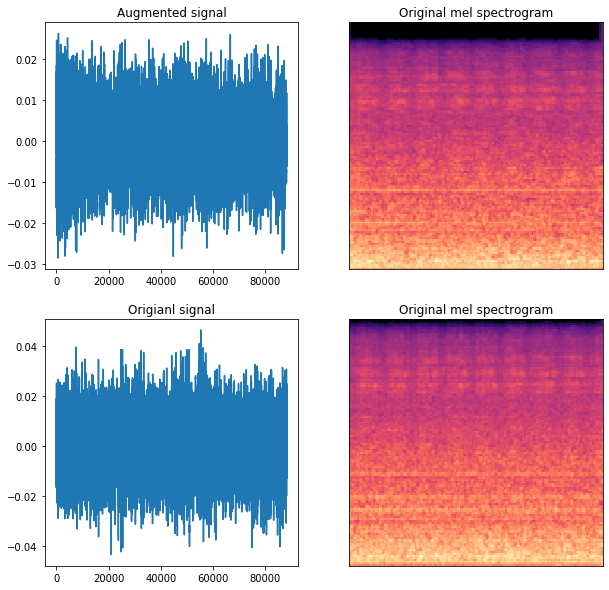

In [24]:
import matplotlib.pyplot as plt

plt.figure(0, figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title("Augmented signal")
plt.plot(one_file_aug)

plt.subplot(2, 2, 3)
plt.title("Origianl signal")
plt.plot(one_file_orig)

plt.subplot(2, 2, 2)
plt.title("Original mel spectrogram")
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(one_file_aug),  ref=np.max))

plt.subplot(2, 2, 4)
plt.title("Original mel spectrogram")
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(one_file_orig),  ref=np.max))
plt.show()

In [7]:
import librosa.output

In [8]:
librosa.output.write_wav(".test1.wav", one_file_orig, 22050)
librosa.output.write_wav(".test2.wav", one_file_aug, 22050)

In [12]:
from IPython.display import Audio
Audio(one_file_orig, rate=22050)

In [13]:
 Audio(one_file_aug, rate=22050)

# Initialization

## set seeds

In [4]:
reset_seed(1324)

# Prep manager (not need to load the data yet)

In [5]:
audio_root = "../dataset/audio"
metadata_root = "../dataset/metadata"

manager = DatasetManager(metadata_root, audio_root, verbose=1)

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


# Get valid scale

In [6]:
alpha = np.linspace(1, 2, 20)
beta = np.linspace(1, 2, 20)
gamma = np.linspace(1, 2, 20)

import itertools

valid_scaling = []
tolerance = 0.01
target = 2
low_target = target - (target * tolerance)
high_target = target + (target * tolerance)

for a, b, g in tqdm.tqdm(itertools.product(alpha, beta, gamma)):
    M = a * b**2 * g**2
    
    if low_target < M < high_target:
        valid_scaling.append((a, b, g))

8000it [00:00, 599518.16it/s]


In [7]:
for valid in valid_scaling:
    print(valid)

(1.0, 1.0, 1.4210526315789473)
(1.0, 1.4210526315789473, 1.0)
(1.0526315789473684, 1.0526315789473684, 1.3157894736842106)
(1.0526315789473684, 1.3157894736842106, 1.0526315789473684)
(1.1052631578947367, 1.1578947368421053, 1.1578947368421053)
(1.1578947368421053, 1.0, 1.3157894736842106)
(1.1578947368421053, 1.3157894736842106, 1.0)
(1.2105263157894737, 1.1052631578947367, 1.1578947368421053)
(1.2105263157894737, 1.1578947368421053, 1.1052631578947367)
(1.263157894736842, 1.0, 1.263157894736842)
(1.263157894736842, 1.263157894736842, 1.0)
(1.368421052631579, 1.0, 1.2105263157894737)
(1.368421052631579, 1.2105263157894737, 1.0)
(1.4736842105263157, 1.0526315789473684, 1.1052631578947367)
(1.4736842105263157, 1.1052631578947367, 1.0526315789473684)
(1.631578947368421, 1.0, 1.1052631578947367)
(1.631578947368421, 1.0526315789473684, 1.0526315789473684)
(1.631578947368421, 1.1052631578947367, 1.0)
(1.7894736842105263, 1.0, 1.0526315789473684)
(1.7894736842105263, 1.0526315789473684, 1.0)

# test every model to check if they are architecturally valid

In [8]:
class ConvBNReLUPool(nn.Sequential):
    def __init__(self, in_size, out_size, kernel_size, stride, padding,
                pool_kernel_size, pool_stride, dropout: float = 0.0):
        super(ConvBNReLUPool, self).__init__(
            nn.Conv2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_size),
            nn.Dropout2d(dropout),
            nn.ReLU6(inplace=True),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride),
        )
        

class ConvReLU(nn.Sequential):
    def __init__(self, in_size, out_size, kernel_size, stride, padding):
        super(ConvReLU, self).__init__(
            nn.Conv2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU6(inplace=True),
        )

In [19]:
class ScalableCnn(nn.Module):
    """
    Compound Scaling based CNN
    see: https://arxiv.org/pdf/1905.11946.pdf
    """

    def __init__(self, dataset: DatasetManager,
                 compound_scales: tuple = (1, 1, 1),
                 initial_conv_inputs=[1, 32, 64, 64],
                 initial_conv_outputs=[32, 64, 64, 64],
                 initial_linear_inputs=[1344, ],
                 initial_linear_outputs=[10, ],
                 initial_resolution=[64, 173],
                 round_up: bool = False,
                 **kwargs
                 ):
        super(ScalableCnn, self).__init__()
        self.compound_scales = compound_scales
        self.dataset = dataset
        round_func = np.floor if not round_up else np.ceil

        alpha, beta, gamma = compound_scales[0], compound_scales[1], compound_scales[2]

        initial_nb_conv = len(initial_conv_inputs)
        initial_nb_dense = len(initial_linear_inputs)

        # Apply compound scaling

        # resolution ----
        # WARNING - RESOLUTION WILL CHANGE THE FEATURES EXTRACTION OF THE SAMPLE
        new_n_mels = int(round_func(initial_resolution[0] * gamma))
        new_n_time_bins = int(round_func(initial_resolution[1] * gamma))
        new_hop_length = int(round_func( (self.dataset.sr * DatasetManager.LENGTH) / new_n_time_bins))

        self.scaled_resolution = (new_n_mels, new_n_time_bins)
        print("new scaled resolution: ", self.scaled_resolution)

        if gamma > 1.0:
            dataset.extract_feature = self.generate_feature_extractor(new_n_mels, new_hop_length)

        # ======== CONVOLUTION PARTS ========
        # ---- depth ----
        scaled_nb_conv = round_func(initial_nb_conv * alpha)
        
        if scaled_nb_conv != initial_nb_conv:  # Another conv layer must be created
            print("More conv layer must be created")
            gaps = np.array(initial_conv_outputs) - np.array(initial_conv_inputs)  # average filter gap
            avg_gap = gaps.mean()

            while len(initial_conv_inputs) < scaled_nb_conv:
                initial_conv_outputs.append(int(round_func(initial_conv_outputs[-1] + avg_gap)))
                initial_conv_inputs.append(initial_conv_outputs[-2])
        
        # ---- width ----
        scaled_conv_inputs = [int(round_func(i * beta)) for i in initial_conv_inputs]
        scaled_conv_outputs = [int(round_func(i * beta)) for i in initial_conv_outputs]
        
        print("new conv layers:")
        print("inputs: ", scaled_conv_inputs)
        print("ouputs: ", scaled_conv_outputs)
        
        # Check how many conv with pooling layer can be used
        nb_max_pooling = int(np.floor(np.min([np.log2(self.scaled_resolution[0]), int(np.log2(self.scaled_resolution[1]))])))
        nb_model_pooling = len(scaled_conv_inputs)

        if nb_model_pooling > nb_max_pooling:
            nb_model_pooling = nb_max_pooling
            
        # fixe initial conv layers
        scaled_conv_inputs[0] = 1
        
        # ======== LINEAR PARTS ========
        # adjust the first dense input with the last convolutional layers
        initial_linear_inputs[0] = self.calc_initial_dense_input(
            self.scaled_resolution,
            nb_model_pooling,
            scaled_conv_outputs
        )
        
        # --- depth ---
        scaled_nb_linear = round_func(initial_nb_dense * alpha)
        
        if scaled_nb_linear != initial_nb_dense:  # Another dense layer must be created
            print("More dense layer must be created")
            dense_list = np.linspace(initial_linear_inputs[0], initial_linear_outputs[-1], scaled_nb_linear + 1)
            initial_linear_inputs = dense_list[:-1]
            initial_linear_outputs = dense_list[1:]
            
        # --- width ---
        scaled_dense_inputs = [int(round_func(i * beta)) for i in initial_linear_inputs]
        scaled_dense_outputs = [int(round_func(i * beta)) for i in initial_linear_outputs]
        
        # fix first and final linear layer
        scaled_dense_inputs[0] = self.calc_initial_dense_input(self.scaled_resolution,
                                                                nb_model_pooling,
                                                                scaled_conv_outputs)
        scaled_dense_outputs[-1] = 10
        
        print("new dense layers:")
        print("inputs: ", scaled_dense_inputs)
        print("ouputs: ", scaled_dense_outputs)

        # ======== BUILD THE MODEL=========
        # features part ----
        features = []

        # Create the layers
        for idx, (inp, out) in enumerate(zip(scaled_conv_inputs, scaled_conv_outputs)):
            if idx < nb_model_pooling:
                dropout = 0.3 if idx != 0 else 0.0
                features.append(ConvBNReLUPool(inp, out, 3, 1, 1, (2, 2), (2, 2), dropout))

            else:
                features.append(ConvReLU(inp, out, 3, 1, 1))

        self.features = nn.Sequential(
            *features,
        )

        # classifier part ----
        linears = []
        for inp, out in zip(scaled_dense_inputs[:-1], scaled_dense_outputs[:-1]):
            print(inp, out)
            linears.append(nn.Linear(inp, out))
            linears.append(nn.ReLU6(inplace=True))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            *linears,
            nn.Linear(scaled_dense_inputs[-1], scaled_dense_outputs[-1])
        )

    def forward(self, x):
        x = x.view(-1, 1, *x.shape[1:])

        x = self.features(x)
        x = self.classifier(x)

        return x

    def calc_initial_dense_input(self, resolution, nb_model_pooling, conv_outputs):
        dim1 = resolution[0]
        dim2 = resolution[1]

        for i in range(int(nb_model_pooling)):
            dim1 = dim1 // 2
            dim2 = dim2 // 2

        return dim1 * dim2 * conv_outputs[-1]

    def generate_feature_extractor(self, n_mels, hop_length):
        #@conditional_cache
        def extract_feature(raw_data, filename = None, cached = False):
            feat = librosa.feature.melspectrogram(
                raw_data, self.dataset.sr, n_fft=2048, hop_length=hop_length, n_mels=n_mels, fmin=0, fmax=self.dataset.sr // 2)
            feat = librosa.power_to_db(feat, ref=np.max)
            return feat

        return extract_feature

In [20]:
def testing_model(**kwargs):
    """The new scallable 1 model feature resolution scaling.
    It is also used as a starter for the new scallable 2 model
    """
    dataset = kwargs["dataset"]
    #compound_scales = kwargs.get("compound_scales", (1.36, 1.0, 1.21))
    compound_scales = kwargs.get("compound_scales", (1.0, 1.0, 1.0))

    parameters = dict(
        dataset=dataset,
        compound_scales = compound_scales,
        initial_conv_inputs=[1, 32, 64, 64, 64, 80],
        initial_conv_outputs=[32, 64, 64, 64, 80, 96],
        initial_linear_inputs=[1344,  677],
        initial_linear_outputs=[677,  10],
        initial_resolution=[78, 210],
        round_up=True,
    )

    return ScalableCnn(**parameters)

In [22]:

from torchsummaryX import summary


model_func = scallable2_new

for valid in valid_scaling:
    print("========================================")
    print("")
    print(valid)
    print("")
    print("========================================")
    
    torch.cuda.empty_cache()
    
    m1 = testing_model(dataset = manager, compound_scales=valid)
    resolution = m1.scaled_resolution

    m1.cuda()
    
    input_tensor = torch.zeros(((1,) + resolution), dtype=torch.float)
    input_tensor = input_tensor.cuda()

    s = summary(m1, input_tensor)


(1.0, 1.0, 1.4210526315789473)

new scaled resolution:  (111, 299)
new conv layers:
inputs:  [1, 32, 64, 64, 64, 80]
ouputs:  [32, 64, 64, 64, 80, 96]
new dense layers:
inputs:  [384, 677]
ouputs:  [677, 10]
384 677
                               Kernel Shape       Output Shape    Params  \
Layer                                                                      
0_features.0.Conv2d_0         [1, 32, 3, 3]  [1, 32, 111, 299]     320.0   
1_features.0.BatchNorm2d_1             [32]  [1, 32, 111, 299]      64.0   
2_features.0.Dropout2d_2                  -  [1, 32, 111, 299]         -   
3_features.0.ReLU6_3                      -  [1, 32, 111, 299]         -   
4_features.0.MaxPool2d_4                  -   [1, 32, 55, 149]         -   
5_features.1.Conv2d_0        [32, 64, 3, 3]   [1, 64, 55, 149]   18.496k   
6_features.1.BatchNorm2d_1             [64]   [1, 64, 55, 149]     128.0   
7_features.1.Dropout2d_2                  -   [1, 64, 55, 149]         -   
8_features.1.ReLU6_3   

/users/samova/lcances/.miniconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


                                 Kernel Shape      Output Shape    Params  \
Layer                                                                       
0_features.0.Conv2d_0           [1, 38, 3, 3]  [1, 38, 91, 244]     380.0   
1_features.0.BatchNorm2d_1               [38]  [1, 38, 91, 244]      76.0   
2_features.0.Dropout2d_2                    -  [1, 38, 91, 244]         -   
3_features.0.ReLU6_3                        -  [1, 38, 91, 244]         -   
4_features.0.MaxPool2d_4                    -  [1, 38, 45, 122]         -   
5_features.1.Conv2d_0          [38, 75, 3, 3]  [1, 75, 45, 122]   25.725k   
6_features.1.BatchNorm2d_1               [75]  [1, 75, 45, 122]     150.0   
7_features.1.Dropout2d_2                    -  [1, 75, 45, 122]         -   
8_features.1.ReLU6_3                        -  [1, 75, 45, 122]         -   
9_features.1.MaxPool2d_4                    -   [1, 75, 22, 61]         -   
10_features.2.Conv2d_0         [75, 75, 3, 3]   [1, 75, 22, 61]     50.7k   

## Prep data


nb file loaded: 7895



nb file loaded: 837


In [30]:
# train and val loaders
train_dataset = Dataset(dataset, train=True, val=False, augments=[], cached=False)
val_dataset = Dataset(dataset, train=True, val=False, augments=[], cached=False)

## Prep training

In [31]:
# create model
torch.cuda.empty_cache()

m1 = model_func()
m1.cuda()

# loss and optimizer
criterion_bce = nn.CrossEntropyLoss(reduction="mean")

optimizer = torch.optim.SGD(
    m1.parameters(),
    weight_decay=1e-3,
    lr=0.05
)

# Augmentation to use
augments = []


In [33]:
# training parameters
nb_epoch = 100
batch_size = 64
nb_batch = len(train_dataset) // batch_size

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# scheduler
lr_lambda = lambda epoch: 0.05 * (np.cos(np.pi * epoch / nb_epoch) + 1)
lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
callbacks = [lr_scheduler]
# callbacks = []

# tensorboard
title = "%s_%s_Cosd-lr_sgd-0.01lr-wd0.001_%de_no_augment" % ( get_datetime(), model_func.__name__, nb_epoch )
tensorboard = SummaryWriter(log_dir="tensorboard/%s" % title, comment=model_func.__name__)

## training

In [35]:
acc_func = CategoricalAccuracy()

for epoch in tqdm.tqdm_notebook(range(nb_epoch)):
    start_time = time.time()
    print("")
    
    acc_func.reset()

    m1.train()

    for i, (X, y) in enumerate(training_loader):        
        # Transfer to GPU
        X = X.cuda()
        y = y.cuda()
        
        # predict
        logits = m1(X)

        weak_loss = criterion_bce(logits, y)

        total_loss = weak_loss

        # calc metrics
#         y_pred = torch.log_softmax(logits, dim=1)
        _, y_pred = torch.max(logits, 1)
        acc = acc_func(y_pred, y)

        # ======== back propagation ========
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # ======== history ========
        print("Epoch {}, {:d}% \t ce: {:.4f} - acc: {:.4f} - took: {:.2f}s".format(
            epoch+1,
            int(100 * (i+1) / nb_batch),
            total_loss.item(),
            acc,
            time.time() - start_time
        ),end="\r")

    # using tensorboard to monitor loss and acc
    tensorboard.add_scalar('train/ce', total_loss.item(), epoch)
    tensorboard.add_scalar("train/acc", 100. * acc, epoch )

    # Validation
    with torch.set_grad_enabled(False):
        # reset metrics
        acc_func.reset()
        m1.eval()

        for X_val, y_val in val_loader:
            # Transfer to GPU
            X_val = X_val.cuda()
            y_val = y_val.cuda()

#             y_weak_val_pred, _ = model(X_val)
            logits = m1(X_val)

            # calc loss
            weak_loss_val = criterion_bce(logits, y_val)

            # metrics
#             y_val_pred =torch.log_softmax(logits, dim=1)
            _, y_val_pred = torch.max(logits, 1)
            acc_val = acc_func(y_val_pred, y_val)

            #Print statistics
            print("Epoch {}, {:d}% \t ce: {:.4f} - acc: {:.4f} - ce val: {:.4f} - acc val: {:.4f} - took: {:.2f}s".format(
                epoch+1,
                int(100 * (i+1) / nb_batch),
                total_loss.item(),
                acc,
                weak_loss_val.item(),
                acc_val,
                time.time() - start_time
            ),end="\r")

        # using tensorboard to monitor loss and acc
        tensorboard.add_scalar('validation/ce', weak_loss_val.item(), epoch)
        tensorboard.add_scalar("validation/acc", 100. * acc_val, epoch )

    for callback in callbacks:
        callback.step()


Epoch 1, 100% 	 ce: 1.9765 - acc: 0.2300 - ce val: 2.0299 - acc val: 0.3322 - took: 22.16s
Epoch 2, 100% 	 ce: 1.8762 - acc: 0.3514 - ce val: 1.6267 - acc val: 0.4099 - took: 22.07s
Epoch 3, 100% 	 ce: 1.1466 - acc: 0.4364 - ce val: 1.5456 - acc val: 0.4999 - took: 22.31s


KeyboardInterrupt: 

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪